In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn
import torch.nn.functional as functional
from torch.autograd import Variable

# Read data

In [16]:
x_item_train = pd.read_csv('../../data/input_formated/withuser_2/x_item_train.csv').iloc[:, 1:]
x_user_train = pd.read_csv('../../data/input_formated/withuser_2/x_user_train.csv').iloc[:, 1:]
y_train = pd.read_csv('../../data/input_formated/withuser_2/y_train.csv').iloc[:, 1:]


In [7]:
x_item_test = pd.read_csv('../../data/input_formated/withuser_2/x_item_test.csv').iloc[:, 1:]
x_user_test = pd.read_csv('../../data/input_formated/withuser_2/x_user_test.csv').iloc[:, 1:]
y_test = pd.read_csv('../../data/input_formated/withuser_2/y_test.csv').iloc[:, 1:]


In [17]:
x_0_data = np.array(x_item_train.iloc[:, 2:], dtype = np.float32)
x_1_data = np.array(x_user_train.iloc[:, 2:], dtype = np.float32)
y_data = np.array(y_train.iloc[:, 2:], dtype=np.float32)

In [26]:
x_0_testdata = np.array(x_item_test.iloc[:, 2:], dtype = np.float32)
x_1_testdata = np.array(x_user_test.iloc[:, 2:], dtype = np.float32)
y_testdata = np.array(y_test.iloc[:, 2:], dtype=np.float32)

# ANN

In [23]:
def mse_loss_vector(a, b):
    return torch.abs((a - b) * (a-b)).mean(dim = 0)

In [22]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y - y_hat).pow(2)))

In [40]:
class ANN_2input(nn.Module):
    def __init__(self, input_0_size, input_1_size, hidden_size, output_size):
        super(ANN_2input, self).__init__()
        self.fc0 = nn.Linear(input_0_size, hidden_size) 
        self.fc1 = nn.Linear(input_1_size, hidden_size)  
        self.activate0 = nn.Sigmoid()
        self.activate1 = nn.Sigmoid()
        self.fc_merge0 = nn.Linear(hidden_size, hidden_size)
        self.fc_merge1 = nn.Linear(hidden_size, hidden_size)
        self.bn_merge = nn.BatchNorm1d(hidden_size,hidden_size)
        self.activate_merge = nn.Sigmoid()
        self.fc = nn.Linear(hidden_size, output_size)
        self.bn = nn.BatchNorm1d(output_size, output_size)
        self.activate = nn.Sigmoid()
        
        
    def forward(self, x_0, x_1):
        h_0 = self.activate0(self.fc0(x_0))
        h_1 = self.activate1(self.fc1(x_1))
        h = self.activate_merge(self.bn_merge(self.fc_merge0(h_0) + self.fc_merge1(h_1)))
        return self.activate(self.bn(self.fc(h)))

In [38]:
def train(x_0, x_1, y, learning_rate, num_epochs, hidden_size, check_point = 100):
    n = int(0.8 * len(y))
    x_0_train = np.array(x_0[:n, :], dtype = np.float32)
    x_0_val = np.array(x_0[n:, :], dtype = np.float32)
    x_1_train = np.array(x_1[:n, :], dtype = np.float32)
    x_1_val = np.array(x_1[n:, :], dtype = np.float32)
    
    y_train = np.array(y[:n, :], dtype = np.float32)
    y_val = np.array(y[n:, :], dtype = np.float32)

    model = ANN_2input(x_0_train.shape[1], x_1_train.shape[1], hidden_size, y_train.shape[1])

    # Loss and Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
    train_loss_list, val_loss_list = [], []

    #early stopping
    max_patience = 100
    patience = 0
    best_val = None
    
    # Train the Model 
    for epoch in range(num_epochs):
        # Convert numpy array to torch Variable
        inputs_0 = Variable(torch.from_numpy(x_0_train))
        inputs_1 = Variable(torch.from_numpy(x_1_train))
        targets = Variable(torch.from_numpy(y_train), requires_grad = False)

        # Forward + Backward + Optimize
        optimizer.zero_grad()  
        outputs = model(inputs_0, inputs_1)
        train_loss = mse_loss_vector(outputs, targets).sum()
        
        train_loss_list.append(train_loss.data[0])

        #validate
        inputs_0 = Variable(torch.from_numpy(x_0_val))
        inputs_1 = Variable(torch.from_numpy(x_1_val))
        targets = Variable(torch.from_numpy(y_val), requires_grad = False)
        outputs = model(inputs_0,inputs_1)   
        val_loss = mse_loss_vector(outputs, targets).sum()
        val_loss_list.append(val_loss.data[0])
        

        train_loss.backward()
        optimizer.step()

        if (epoch == 0) or ((epoch+1) % check_point == 0):
            print ('Epoch [%d/%d], Loss: %.4f, %.4f' 
                   %(epoch+1, num_epochs, train_loss.data[0], val_loss.data[0]))
        if (best_val is None) or ((best_val is not None) and (val_loss < best_val)) :
            best_val = val_loss
            patience = max_patience
        else:
            patience -= 1
        if patience == 0:
            print 'Early stopping at %d' % epoch
            break            

    #Plot the graph
    plt.plot(range(len(val_loss_list)), train_loss_list, label='train')
    plt.plot(range(len(val_loss_list)), val_loss_list, label ='validate')
    
    plt.legend()
    plt.show()
    
    return model

Epoch [1/500], Loss: 0.1066, 0.1067
Epoch [100/500], Loss: 0.0581, 0.0583
Epoch [200/500], Loss: 0.0579, 0.0580
Epoch [300/500], Loss: 0.0578, 0.0580
Epoch [400/500], Loss: 0.0578, 0.0580
Epoch [500/500], Loss: 0.0578, 0.0580


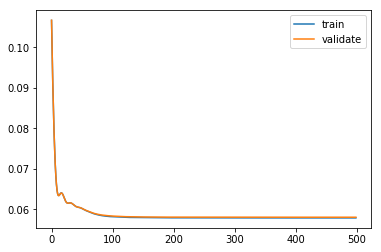

In [24]:
model = train(x_0_data, x_1_data, y_data, learning_rate = 0.01, num_epochs= 500, check_point = 100)

In [25]:
inputs_0 = Variable(torch.from_numpy(x_0_data))
inputs_1 = Variable(torch.from_numpy(x_1_data))
targets = Variable(torch.from_numpy(y_data[:, 0] * 5), requires_grad = False)
outputs = Variable(model(inputs_0, inputs_1).data[:,0] * 5)
print rmse(outputs, targets).sum()

Variable containing:
 1.0942
[torch.FloatTensor of size 1]



Epoch [1/500], Loss: 1.0880, 1.0887
Epoch [100/500], Loss: 0.0570, 0.0572
Epoch [200/500], Loss: 0.0569, 0.0571
Epoch [300/500], Loss: 0.0569, 0.0570
Epoch [400/500], Loss: 0.0568, 0.0570
Epoch [500/500], Loss: 0.0568, 0.0570


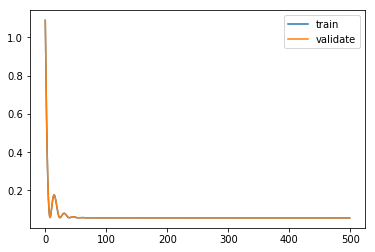

In [34]:
model = train(x_0_data, x_1_data, y_data, learning_rate = 0.1, num_epochs= 500, check_point = 100)

In [33]:
inputs_0 = Variable(torch.from_numpy(x_0_data))
inputs_1 = Variable(torch.from_numpy(x_1_data))
targets = Variable(torch.from_numpy(y_data[:, 0] * 5), requires_grad = False)
outputs = Variable(model(inputs_0, inputs_1).data[:,0] * 5)
print rmse(outputs, targets).sum()

Variable containing:
 1.0884
[torch.FloatTensor of size 1]



In [35]:
inputs_0 = Variable(torch.from_numpy(x_0_data))
inputs_1 = Variable(torch.from_numpy(x_1_data))
targets = Variable(torch.from_numpy(y_data[:, 0] * 5), requires_grad = False)
outputs = Variable(model(inputs_0, inputs_1).data[:,0] * 5)
print rmse(outputs, targets).sum()

Variable containing:
 1.0878
[torch.FloatTensor of size 1]



Epoch [1/500], Loss: 0.1556, 0.1555
Epoch [100/500], Loss: 0.0551, 0.0553
Epoch [200/500], Loss: 0.0542, 0.0544
Epoch [300/500], Loss: 0.0538, 0.0540
Epoch [400/500], Loss: 0.0536, 0.0539
Epoch [500/500], Loss: 0.0537, 0.0539


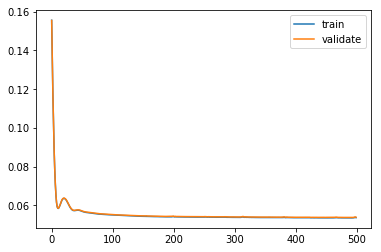

In [41]:
model = train(x_0_data, x_1_data, y_data, learning_rate = 0.1, hidden_size = 10, num_epochs= 500, check_point = 100)

In [42]:
inputs_0 = Variable(torch.from_numpy(x_0_data))
inputs_1 = Variable(torch.from_numpy(x_1_data))
targets = Variable(torch.from_numpy(y_data[:, 0] * 5), requires_grad = False)
outputs = Variable(model(inputs_0, inputs_1).data[:,0] * 5)
print rmse(outputs, targets).sum()

Variable containing:
 1.0675
[torch.FloatTensor of size 1]



Epoch [1/5000], Loss: 0.1556, 0.1555
Epoch [500/5000], Loss: 0.0535, 0.0537
Epoch [1000/5000], Loss: 0.0532, 0.0535
Epoch [1500/5000], Loss: 0.0532, 0.0534
Epoch [2000/5000], Loss: 0.0531, 0.0534
Epoch [2500/5000], Loss: 0.0531, 0.0534
Epoch [3000/5000], Loss: 0.0531, 0.0534
Epoch [3500/5000], Loss: 0.0531, 0.0534
Epoch [4000/5000], Loss: 0.0531, 0.0534
Epoch [4500/5000], Loss: 0.0531, 0.0534
Epoch [5000/5000], Loss: 0.0531, 0.0534


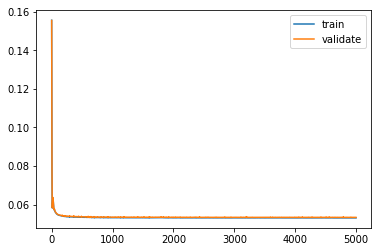

In [43]:
model = train(x_0_data, x_1_data, y_data, learning_rate = 0.1, hidden_size = 10, num_epochs= 5000, check_point = 500)

In [44]:
inputs_0 = Variable(torch.from_numpy(x_0_data))
inputs_1 = Variable(torch.from_numpy(x_1_data))
targets = Variable(torch.from_numpy(y_data[:, 0] * 5), requires_grad = False)
outputs = Variable(model(inputs_0, inputs_1).data[:,0] * 5)
print rmse(outputs, targets).sum()

Variable containing:
 1.0640
[torch.FloatTensor of size 1]



In [115]:
inputs_0 = Variable(torch.from_numpy(x_0_testdata))
inputs_1 = Variable(torch.from_numpy(x_1_testdata))
targets = Variable(torch.from_numpy(y_testdata[:, 0] * 5), requires_grad = False)
outputs = Variable(model(inputs_0, inputs_1).data[:,0] * 5)
print rmse(outputs, targets).sum()

Variable containing:
 1.0650
[torch.FloatTensor of size 1]



In [116]:
torch.save(model, 'train_withuser.pth')

/home/anla/Apps/anaconda2/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type ANN_2input. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Test

In [112]:
def test(x_0, x_1, y):
    inputs_0 = Variable(torch.from_numpy(np.array(x_0, dtype = np.float32)))
    inputs_1 = Variable(torch.from_numpy(np.array(x_1, dtype = np.float32)))
    outputs = model(inputs_0, inputs_1).data[:,0]
    tmp = y
    tmp['output'] = outputs
    target = np.array(tmp.groupby('movie_id')['mean_rate'].mean().reset_index(), dtype = np.float32)[:, 1].reshape((-1, 1))
    output = np.array(tmp.groupby(['movie_id'])['output'].mean().reset_index(), dtype = np.float32)[: ,1].reshape((-1,1))
    return np.mean(np.sqrt((target - output) * (target - output)))

In [113]:
test(x_item_train.iloc[:, 2:], x_user_train.iloc[:, 2:], y_train)

0.097943306

In [114]:
test(x_item_test.iloc[:, 2:], x_user_test.iloc[:, 2:], y_test)

0.092553891